In [1]:
# reference: https://www.kaggle.com/code/ankasor/improved-lung-segmentation-using-watershed/notebook

In [2]:
%matplotlib inline

import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import glob

from skimage import measure, segmentation
from tqdm import tqdm

from utils import (
    plot_3d, load_scan,
    optimized_separate_lungs
)

# Some constants 
INPUT_FOLDER = r'D:/masters_datasets/LUNA16-original/LUNA16_Images/*.mhd'
exams = glob.glob(INPUT_FOLDER)
print(len(exams))
exams.sort()

888


### Loading the files

(133, 512, 512)
Original Slice


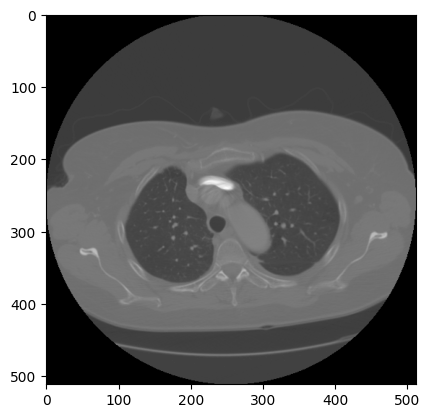

In [3]:
first_exam_pixels = load_scan(exams[7])
print(first_exam_pixels.shape)
print ("Original Slice")
slice = 100
plt.imshow(first_exam_pixels[slice], cmap=plt.cm.gray)
plt.show()

In [4]:
print(first_exam_pixels.shape)

(133, 512, 512)


### Generate markers

In [5]:
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
# test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(first_exam_pixels[slice])
# print ("Internal Marker")
# plt.imshow(test_patient_internal, cmap='gray')
# plt.show()
# print ("External Marker")
# plt.imshow(test_patient_external, cmap='gray')
# plt.show()
# print ("Watershed Marker")
# plt.imshow(test_patient_watershed, cmap='gray')
# plt.show()

### Separate lungs

In [6]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = segmentation.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

#Some Testcode:
# (test_segmented, test_lungfilter, test_outline, 
#  test_watershed, test_sobel_gradient, test_marker_internal, 
#  test_marker_external, test_marker_watershed) = seperate_lungs(
#      first_exam_pixels[slice]
# )

# print ("Sobel Gradient")
# plt.imshow(test_sobel_gradient, cmap='gray')
# plt.show()
# print ("Watershed Image")
# plt.imshow(test_watershed, cmap='gray')
# plt.show()
# print ("Outline after reinclusion")
# plt.imshow(test_outline, cmap='gray')
# plt.show()
# print ("Lungfilter after closing")
# plt.imshow(test_lungfilter, cmap='gray')
# plt.show()
# print ("Segmented Lung")
# plt.imshow(test_segmented, cmap='gray')
# plt.show()

### multiple layers

In [7]:
def segmented_entire_image(image):
    for i, axial_slice in tqdm(enumerate(image)):
        image[i] = optimized_separate_lungs(axial_slice)

    return image

In [8]:
# segmented_lungs = segmented_entire_image(first_exam_pixels)
# print(segmented_lungs.shape)

In [9]:
# plot_3d(segmented_lungs, 0)

### Batch visualization

In [10]:
for i in tqdm(range(719, 887)):
    current_exam = load_scan(exams[i])
    # im = sitk.GetImageFromArray(current_exam)
    # sitk.WriteImage(im, 'generated/exam.nrrd', True)

    segmented_lungs = segmented_entire_image(current_exam)
    # ma = sitk.GetImageFromArray(segmented_lungs)
    # sitk.WriteImage(ma, 'generated/mask.nrrd', True)
    output = np.unique(segmented_lungs, return_counts=True)
    name = str(i) + '-' + str(round(output[1][1]/output[1][0], 5))
    plot_3d(segmented_lungs, 0, name='visu-watershed/'+name)

187it [06:41,  2.15s/it]00:00<?, ?it/s]
310it [12:30,  2.42s/it]08:11<22:48:13, 491.58s/it]
124it [03:55,  1.90s/it]22:38<32:50:16, 712.15s/it]
138it [05:03,  2.20s/it]27:30<23:51:17, 520.47s/it]
129it [04:38,  2.16s/it]33:58<21:20:02, 468.31s/it]
137it [05:12,  2.28s/it]39:56<19:23:47, 428.39s/it]
513it [15:33,  1.82s/it]46:18<18:33:49, 412.53s/it]
245it [07:42,  1.89s/it]1:04:18<28:12:49, 630.87s/it]
115it [03:30,  1.83s/it]1:13:29<26:54:04, 605.28s/it]
468it [14:10,  1.82s/it]1:17:54<22:02:24, 499.02s/it]
133it [04:01,  1.82s/it][1:33:59<28:12:40, 642.79s/it]
278it [08:15,  1.78s/it][1:38:50<23:20:30, 535.23s/it]
238it [06:59,  1.76s/it][1:48:40<23:54:54, 551.89s/it]
135it [04:08,  1.84s/it][1:56:38<22:48:12, 529.63s/it]
224it [07:15,  1.95s/it][2:01:46<19:47:10, 462.54s/it]
241it [08:21,  2.08s/it][2:10:21<20:19:39, 478.30s/it]
297it [15:46,  3.19s/it][2:21:20<22:29:21, 532.64s/it]
114it [05:56,  3.13s/it][2:39:29<29:21:28, 699.93s/it]
474it [16:07,  2.04s/it][2:46:55<25:59:24, 623